In [1]:
import sys
import os

sys.path.insert(0, os.path.join(os.getcwd(), "../src"))
from ml2048.prelude import *

This notebook load the agent, simulate a number of games, and keep the best of them.

It can visualize the game by drawing the board in particular step.

Thus, it can also generate a replay video.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.path as mpath

from matplotlib.artist import Artist
from matplotlib.axes import Axes
from matplotlib.text import Text
from matplotlib.figure import Figure
from matplotlib.patches import FancyBboxPatch, BoxStyle
from matplotlib.animation import FuncAnimation

import shutil

if shutil.which("ffmpeg") is None:
    # Tell matplotlib where is ffmpeg
    ffmpeg_bin = r"Programs\ffmpeg-master-20231127win64-gpl\bin\ffmpeg.exe"
    mpl.rcParams["animation.ffmpeg_path"] = str(Path.home() / ffmpeg_bin)

In [3]:
from ml2048.game_numba import VecGame
from ml2048.runner import VecRunner
from ml2048.replay import ReplayRecorder, RecordBuffer
from ml2048.policy import Policy
from ml2048.policy.actor_critic import CNNActorCriticPolicy
from ml2048.policy.random import RandomPolicy
from ml2048.policy.max_likely import MaxLikelyPolicy


def collect_buffers(
    runner: VecRunner,
    policy: Policy,
    recorder: ReplayRecorder,
    steps: int,
    result_max: int,
) -> list[RecordBuffer]:
    """
    Collect best results in fixed steps.

    {result_max} results are returned at most. They are sorted by max tile and step count.
    """

    from heapq import heappush, heappushpop
    import time

    ready_buffers = recorder.ready_buffers

    pq = []

    last_report = time.monotonic()

    for idx in range(steps):
        runner.step_once(policy)

        now = time.monotonic()
        if now - last_report >= 60:
            print(f"Progress {idx / steps:.1%}")
            last_report = now

        while ready_buffers:
            buffer = ready_buffers.popleft()
            item = (buffer.maxcell, buffer.steps, buffer.id, buffer)
            if len(pq) >= result_max:
                # discard small item
                heappushpop(pq, item)
            else:
                heappush(pq, item)
    pq.sort()

    return [s[-1] for s in pq]

In [4]:
numba.set_num_threads(os.cpu_count() // 2)

game_size = 1024
model_path = r"../assets/ml2048_20240330_013340-epoch-2500.pt"

device = "cuda:0"
game = VecGame(game_size)
runner = VecRunner(game, game_size, sample_device=device)
recorder = ReplayRecorder(game_size, game_size)
runner.add_callback(VecRunner.EVENT_PREPARED, recorder.on_prepared)
runner.add_callback(VecRunner.EVENT_STEPPED, recorder.on_stepped)
if True:
    policy = CNNActorCriticPolicy(share_encoder=True)
    state_dict = torch.load(model_path)["policy_state"]
    policy.load_state_dict(state_dict)
    policy = MaxLikelyPolicy(policy)
else:
    policy = RandomPolicy()

policy = policy.to(device)

# Run 8k steps to collect the best 100 records
# It takes about a minute in recent mid-range GPU
pq = collect_buffers(runner, policy, recorder, 8000, 100)

# release the memory
policy = game = recorder = runner = None

# dump the first and last entry
print(pq[0], pq[-1], sep="\n")

RecordBuffer(id=1000, steps=5216, terminated=True, maxcell=13, score=132172.0)
RecordBuffer(id=837, steps=6762, terminated=True, maxcell=13, score=173244.0)


In [5]:
# Save/Load the results since 16384 (if any) is rare.

import pickle

# Path("16384.dat").write_bytes(pickle.dumps(pq))
# pq = pickle.loads(Path("16384.dat").read_bytes())

print(pq[0])
print(pq[-1])

RecordBuffer(id=1401, steps=5159, terminated=True, maxcell=13, score=131300.0)
RecordBuffer(id=457, steps=7661, terminated=True, maxcell=14, score=223192.0)


In [6]:
from ml2048.visualization import make_tile_locs, make_tile_styles, BACKGROUND_COLOR


class FramePainter:
    """
    Draw 2048 board in static images or animations
    """

    tiles: list[FancyBboxPatch]
    texts: list[Text]
    background_color: str = BACKGROUND_COLOR

    def __init__(
        self,
        ax: Axes | None = None,
        data: np.ndarray | None = None,
        blit: bool = False,
    ) -> None:
        """

        :param blit: Set to True when used in FuncAnimation(blit=True)
        """
        self.start_frame = 0
        self.styles = make_tile_styles()
        self.locs = make_tile_locs()

        if ax is not None:
            self.setup_axes(ax)

        self._blit = blit
        self._data = data

    def draw_frame(
        self,
        n: int,
        data: np.ndarray | None = None,
        blit: bool | None = False,
    ) -> list[Artist]:
        if blit is None:
            blit = self._blit

        if data is None:
            data = self._data

        state = data[n, :]

        if blit and n > 0:
            indices = np.flatnonzero(state != data[n - 1, :])
        else:
            indices = range(16)

        changed = []

        for idx in indices:
            power = state[idx]
            style = self.styles[power]

            tile = self.tiles[idx]
            tile.set_facecolor(style.background)

            text = self.texts[idx]
            if power >= 1:
                text.set_text(str(2**power))
            else:
                text.set_text("")

            text.set_fontsize(style.font_size)
            text.set_color(style.color)

            changed.extend((tile, text))

        return changed

    def setup_axes(
        self,
        ax: Axes,
    ):
        """
        Draw the base board with 16 empty tiles.
        """
        ax.set_axis_off()
        ax.set_aspect(1)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

        # Draw the background ourselves
        ax.add_patch(
            FancyBboxPatch(
                (0, 0),
                1,
                1,
                facecolor=self.background_color,
                linewidth=0,
                boxstyle=BoxStyle.Round(0, 0),
            )
        )

        self.tiles = []
        self.texts = []

        for i, loc in enumerate(self.locs):
            tile = ax.add_patch(
                FancyBboxPatch(
                    (loc.x, loc.y),
                    loc.size,
                    loc.size,
                    linewidth=0,
                    facecolor=self.styles[0].background,
                    boxstyle=BoxStyle.Round(0, loc.size * 0.05),
                    animated=True,
                )
            )
            self.tiles.append(tile)

            text = ax.text(
                loc.x + loc.size / 2,
                loc.y + loc.size / 2,
                "",
                fontsize=self.styles[0].font_size,
                fontweight="bold",
                color=self.styles[0].color,
                fontfamily="sans-serif",
                ha="center",
                va="center_baseline",
                transform=ax.transAxes,
                animated=True,
            )
            self.texts.append(text)

    def draw_init(self) -> list[Artist]:
        for tile in self.tiles:
            tile.set_facecolor(self.styles[0].background)

        for text in self.texts:
            text.set_text("")

        res = []
        res.extend(self.tiles)
        res.extend(self.texts)
        return res

Draw last state of the best replay, `pq[-1]`

RecordBuffer(id=457, steps=7661, terminated=True, maxcell=14, score=223192.0)


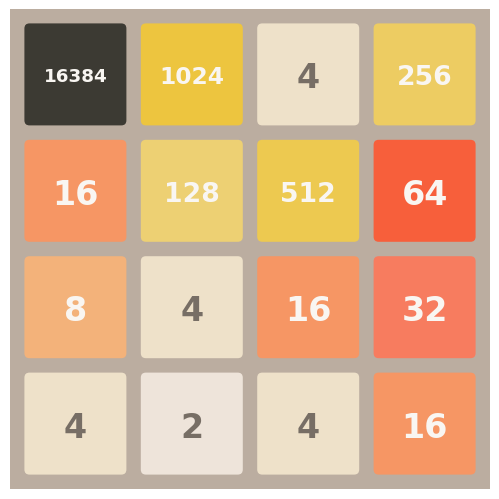

In [7]:
# Draw static image from the best result

buffer = pq[-1]
print(buffer)

state, action, score = buffer.contiguous_result()
total_step = state.shape[0]
step = total_step - 1

fig, ax = plt.subplots(
    figsize=(4.8, 4.8),
    gridspec_kw=dict(zip(("left", "bottom", "right", "top"), (0, 0, 1, 1))),
)

painter = FramePainter(ax, state)
_ = painter.draw_frame(step)
# fig.savefig("out.png")

Animate the best replay, or part of the replay.

RecordBuffer(id=1401, steps=5159, terminated=True, maxcell=13, score=131300.0)


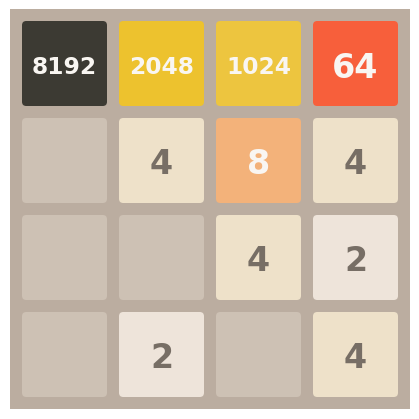

In [8]:
# Generate animation

buffer = pq[-1]
print(buffer)

state, action, score = buffer.contiguous_result()
total_step = state.shape[0]

# change start and stop to specify the video range
# For the full replay video, use start=0 and stop=total_step
start = total_step - 500
stop = total_step - 400
state2 = state[start:stop, :]


fig, ax = plt.subplots(
    figsize=(4, 4),
    gridspec_kw=dict(zip(("left", "bottom", "right", "top"), (0, 0, 1, 1))),
)

painter = FramePainter(ax, data=state2, blit=True)
ani = FuncAnimation(
    fig,
    func=painter.draw_frame,
    init_func=painter.draw_init,
    frames=total_step,
    interval=200,
    blit=True,
    repeat_delay=1000 * 5,
)
# ani.save("out.mp4")

from IPython.display import HTML

HTML(ani.to_html5_video())